# Final assignment

## Instructions

- Read the instructions for the final assignment from the [course page](https://sustainability-gis.readthedocs.io/en/latest/lessons/final-assignment/final-assignment.html).
- To get help with Markdown formatting check [this page](https://www.markdownguide.org/cheat-sheet/).
- If you don't know how to add a Markdown cell check [this page](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook)

## Add your work below

Mix markdown cells with code cells regularly to explain and document your work / codes (in a similar manner as how the Exercises of this course were written). 
Below we provide you a suggestion for the structure of the report by listing the main components that would be good to include in your work. However, you do not necessarily need to follow this structure and you can adjust the headings as you see best.

## 1. Introduction

"The global attention to transport has continued in recent years. World leaders recognized unanimously at the 2012 United Nations Conference on Sustainable Development (Rio +20) that transportation and mobility are central to sustainable development. Sustainable transportation can enhance economic growth and improve accessibility. Sustainable transport achieves better integration of the economy while respecting the environment. improving social equity, health, resilience of cities, urban-rural linkages and productivity of rural areas"

My two focus cities: Memphis, TN and Austin, TX
Comparing the cities on three indicators from SDG target 11.2:
- Road traffic deaths per 100,000 population
 Preliminary research:
 Memphis: 250 deaths in 2020 / 651,932 total population = 38 deaths per 100,000
 Austin: 74 deaths in 2018 / 935,755 total population = 7.9 deaths per 100,000
- Access to all-weather road (% access within [x] km distance to road)
- Percentage of people within 0.5km of public transit running at least every 20 minutes.

## 2. Data and methods

Describe your data (list also the used data sources) and give an overview of the methods that you use in your work.

Data sources for Crash Reports: 
data.austintexas.gov
TN Department of Safety & Homeland Security 
Data sources for Public Transit:
General Transit Feed Specification data (GTFS) fetched from transitland

In [3]:
# Data processing
import zipfile
with zipfile.ZipFile("Memphis_TN_transitfeed2.zip","r") as zip_ref:
    zip_ref.extractall("Memphis_TN_transitfeed")

In [6]:
import pandas as pd
df = pd.read_csv('Memphis_TN_transitfeed/stops.txt', delimiter = ",")
df

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,NaN,0
1,7,AIRKETSN,AIRWAYS BLVD@KETCHUM,AIRWAYS BLVD & KETCHUM RD,35.079543,-89.984917,NaN,NaN,NaN,NaN,NaN,0
2,10,CLEMA1SN,CLEVELAND@MADISON,N CLEVELAND ST & COURT AVE,35.139020,-90.016438,NaN,NaN,NaN,NaN,NaN,0
3,15,FOUGEOSF,4TH ST@ GEORGIA AVE,S 4TH ST & E GEORGIA AVE,35.128896,-90.050605,NaN,NaN,NaN,NaN,NaN,0
4,24,FROGEPNN,CENTRAL STATION,S FRONT ST & E CALHOUN AVE,35.132731,-90.060719,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3503,7096,THIWEANF,THIRD@WEAVER,0 S 3RD ST & DRIVEWAY,35.012262,-90.096245,NaN,NaN,NaN,NaN,NaN,0
3504,7097,THIDELNN,THIRD@DELTA,0 S 3RD ST & DELTA RD,35.019798,-90.088678,NaN,NaN,NaN,NaN,NaN,0
3505,7098,THISHENF,THIRD@SHELBY,0 S 3RD ST & RAMP,35.021479,-90.087010,NaN,NaN,NaN,NaN,NaN,0
3506,7099,THIFORNM,THIRD@FORD,0 S 3RD ST & WESTVIEW RD,35.025341,-90.083154,NaN,NaN,NaN,NaN,NaN,0


In [20]:
import geopandas as gpd
from shapely.geometry import Point, LineString

# creating a geometry column 
geometry = [Point(xy) for xy in zip(df['stop_lon'], df['stop_lat'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry
0,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,NaN,0,POINT (-89.89707 35.22156)
1,7,AIRKETSN,AIRWAYS BLVD@KETCHUM,AIRWAYS BLVD & KETCHUM RD,35.079543,-89.984917,NaN,NaN,NaN,NaN,NaN,0,POINT (-89.98492 35.07954)
2,10,CLEMA1SN,CLEVELAND@MADISON,N CLEVELAND ST & COURT AVE,35.139020,-90.016438,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.01644 35.13902)
3,15,FOUGEOSF,4TH ST@ GEORGIA AVE,S 4TH ST & E GEORGIA AVE,35.128896,-90.050605,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.05061 35.12890)
4,24,FROGEPNN,CENTRAL STATION,S FRONT ST & E CALHOUN AVE,35.132731,-90.060719,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.06072 35.13273)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,7096,THIWEANF,THIRD@WEAVER,0 S 3RD ST & DRIVEWAY,35.012262,-90.096245,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.09624 35.01226)
3504,7097,THIDELNN,THIRD@DELTA,0 S 3RD ST & DELTA RD,35.019798,-90.088678,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.08868 35.01980)
3505,7098,THISHENF,THIRD@SHELBY,0 S 3RD ST & RAMP,35.021479,-90.087010,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.08701 35.02148)
3506,7099,THIFORNM,THIRD@FORD,0 S 3RD ST & WESTVIEW RD,35.025341,-90.083154,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.08315 35.02534)


<AxesSubplot:>

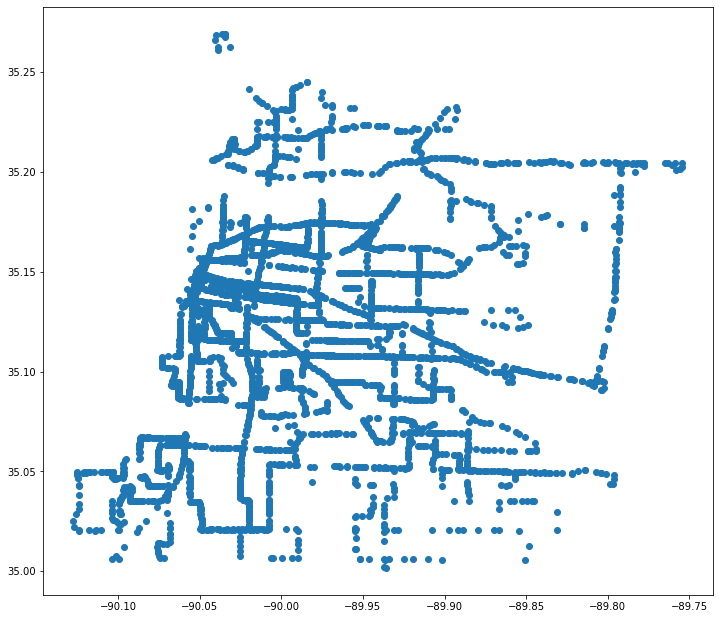

In [12]:
gdf.plot(figsize = (12, 12))

In [13]:
shapes = pd.read_csv('Memphis_TN_transitfeed/shapes.txt', delimiter = ",")
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,37056,35.076276,-89.932316,1,0.0000
1,37056,35.076249,-89.932261,2,0.0058
2,37056,35.076133,-89.932261,3,0.0188
3,37056,35.076008,-89.932272,4,0.0329
4,37056,35.075945,-89.932284,5,0.0399
...,...,...,...,...,...
27777,37355,35.155678,-90.046659,390,24.4704
27778,37355,35.155797,-90.047162,391,24.5175
27779,37355,35.155960,-90.047788,392,24.5773
27780,37355,35.156018,-90.048041,393,24.6001


In [16]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(shapes['shape_pt_lon'], shapes['shape_pt_lat'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
shapes_gdf = gpd.GeoDataFrame(shapes, crs=crs, geometry=geometry)
shapes_gdf

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,37056,35.076276,-89.932316,1,0.0000,POINT (-89.93232 35.07628)
1,37056,35.076249,-89.932261,2,0.0058,POINT (-89.93226 35.07625)
2,37056,35.076133,-89.932261,3,0.0188,POINT (-89.93226 35.07613)
3,37056,35.076008,-89.932272,4,0.0329,POINT (-89.93227 35.07601)
4,37056,35.075945,-89.932284,5,0.0399,POINT (-89.93228 35.07594)
...,...,...,...,...,...,...
27777,37355,35.155678,-90.046659,390,24.4704,POINT (-90.04666 35.15568)
27778,37355,35.155797,-90.047162,391,24.5175,POINT (-90.04716 35.15580)
27779,37355,35.155960,-90.047788,392,24.5773,POINT (-90.04779 35.15596)
27780,37355,35.156018,-90.048041,393,24.6001,POINT (-90.04804 35.15602)


In [29]:

# start with an empty list
result = []
# group by shape_id then transform into linestrings
grouped = shapes_gdf.groupby("shape_id")['geometry'].apply(lambda x: LineString(x.tolist()))
grouped

shape_id
37056    LINESTRING (-89.93232 35.07628, -89.93226 35.0...
37058    LINESTRING (-89.93612 35.00164, -89.93679 35.0...
37059    LINESTRING (-90.04781 35.15658, -90.04762 35.1...
37061    LINESTRING (-89.94015 35.17624, -89.93990 35.1...
37064    LINESTRING (-90.05896 35.13409, -90.05894 35.1...
                               ...                        
37256    LINESTRING (-90.01904 35.15837, -90.01903 35.1...
37258    LINESTRING (-89.93232 35.07628, -89.93226 35.0...
37259    LINESTRING (-89.91099 35.22175, -89.91001 35.2...
37354    LINESTRING (-90.04781 35.15658, -90.04762 35.1...
37355    LINESTRING (-89.91001 35.22174, -89.90938 35.2...
Name: geometry, Length: 81, dtype: geometry

geopandas.geoseries.GeoSeries

## 3. Data analysis + Results

Add and explain your analysis workflow below here.

In [9]:
import pandas as pd
from pyrosm import OSM, get_data

# We fetch data for Memphis from OSM
osm = OSM(get_data("memphis"))

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")

Downloaded Protobuf data 'Memphis.osm.pbf' (16.64 MB) to:
'/tmp/pyrosm/Memphis.osm.pbf'


In [11]:
roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [2]:
# View the unique road labels 
roads["highway"].unique()

array(['residential', 'service', 'tertiary', 'unclassified', 'primary',
       'tertiary_link', 'secondary_link', 'motorway_link', 'secondary',
       'primary_link', 'motorway', 'trunk_link', 'trunk', 'living_street',
       'rest_area', 'residential_link'], dtype=object)

In [6]:
roads.head()

,access,area,bicycle,bridge,cycleway,foot,highway,junction,lanes,lit,...,surface,tunnel,turn,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,None,None,None,residential,None,None,None,...,None,None,None,12772799,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"MULTILINESTRING ((-90.19383 35.21924, -90.1938...",2611.0
1,None,None,None,None,None,None,residential,None,None,None,...,None,None,None,12772805,0,-1,"{""source:geometry"":""https://gis.arkansas.gov/""...",way,"MULTILINESTRING ((-90.35716 35.00212, -90.3573...",237.0
2,None,None,None,None,None,None,service,None,None,None,...,None,None,None,12772806,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"MULTILINESTRING ((-90.35716 35.00212, -90.3564...",3344.0
3,None,None,None,None,None,None,residential,None,None,None,...,None,None,None,12772812,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"MULTILINESTRING ((-90.18696 35.19314, -90.1870...",279.0
4,None,None,None,None,None,None,tertiary,None,None,None,...,None,None,None,12772821,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"MULTILINESTRING ((-90.19343 35.16968, -90.1934...",558.0


In [3]:
# Parse nodes and edges
# Uses osm instance defined previously
nodes, edges = osm.get_network(network_type="driving", nodes=True)

In [4]:
# Count values of the edges' speed limits, including all NaN values
edges["maxspeed"].value_counts(dropna=False)

NaN       552827
45 mph      4714
40 mph      4114
55 mph      2546
65 mph      1918
35 mph      1471
30 mph       594
50 mph       555
70 mph       459
15 mph       322
20 mph       305
19 mph       138
25 mph        61
17 mph        57
10 mph        39
80            30
45            25
70            18
30            11
18 mph         2
5 mph          1
35             1
Name: maxspeed, dtype: int64

<AxesSubplot:>

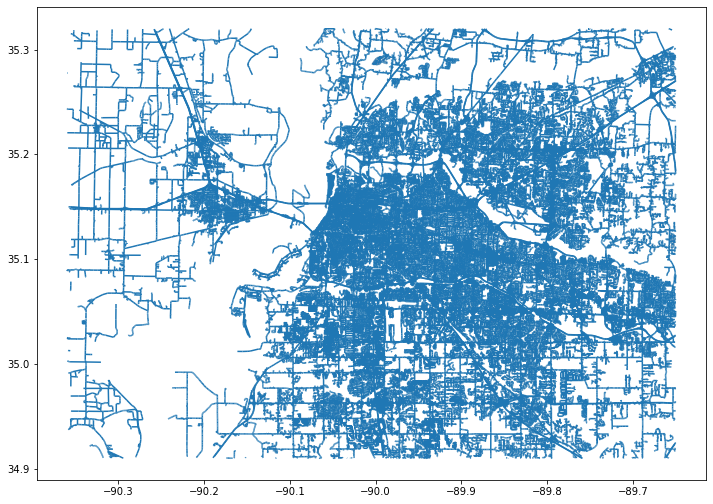

In [7]:
edges.plot(figsize = (12,12))

In [2]:
## Austin crash fatality data

import requests 
r = requests.get('https://www.austintexas.gov/police/reports/advance_search.cfm')

In [3]:
print(r.url)

https://www.austintexas.gov/police/reports/advance_search.cfm


In [14]:
r.encoding

'UTF-8'

In [1]:
payload = {'startdate': '01%2F07%2F2020', 'numdays': ['6']}
r = requests.get('https://www.austintexas.gov/police/reports/advance_search.cfm')
print(r.url)

NameError: name 'requests' is not defined

## 4. Discussion

Add discussion here.

## 5. References

TN Department of Safety and Homeland Security
https://www.tn.gov/content/dam/tn/safety/documents/dailyfatalitybycounty2020.pdf
Austin TX Traffic Fatalities 
https://www.austintexas.gov/department/traffic-fatalities